## Load

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

np.random.seed=42

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/github/p_metaheuristic/data/log


In [2]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

In [3]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [4]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}

uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [5]:
uef[uef.port==1].describe()

,mean_return,var_return,port
count,2000.000000,2000.000000,2000.0
mean,0.006825,0.001579,1.0
std,0.002334,0.001116,0.0
min,0.002784,0.000642,1.0
25%,0.004804,0.000716,1.0
50%,0.006825,0.001058,1.0
75%,0.008845,0.002150,1.0
max,0.010865,0.004776,1.0


In [6]:
df_stats[df_stats.port==1].describe()

,port,i,r_mean,r_std
count,31.0,31.000000,31.000000,31.000000
mean,1.0,16.000000,0.003504,0.045723
std,0.0,9.092121,0.002186,0.007296
min,1.0,1.000000,0.000141,0.035848
25%,1.0,8.500000,0.002043,0.040043
50%,1.0,16.000000,0.003286,0.045450
75%,1.0,23.500000,0.004725,0.050112
max,1.0,31.000000,0.010865,0.069105


In [7]:
df_cov_mx[df_cov_mx.port==1].describe()

,port,i,j,cov
count,496.0,496.000000,496.000000,496.000000
mean,1.0,11.000000,21.000000,0.556209
std,0.0,7.423686,7.423686,0.178871
min,1.0,1.000000,1.000000,0.139539
25%,1.0,5.000000,16.000000,0.452670
50%,1.0,10.000000,22.000000,0.554651
75%,1.0,16.000000,27.000000,0.654551
max,1.0,31.000000,31.000000,1.000000


In [8]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        df['log_iter'] = df.index.values
        df.loc[df[-1:].index, 'last_iter'] = 1
        return df
    except:
        print(filename)


futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


In [9]:
all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
print(all_data.shape)
best_data = all_data[all_data.last_iter==1]
print(best_data.shape)

(4020, 19)
(40, 19)


In [10]:
best_data.tag.value_counts()

tuning_iter    40
Name: tag, dtype: int64

## Ajuste dos Parâmetros

### Iterations

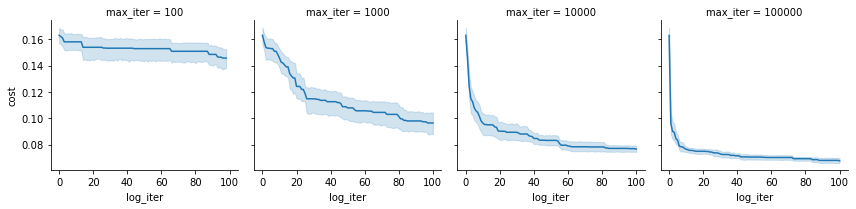

In [11]:
tag = 'tuning_iter'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='max_iter', kind='line', height=3)

In [12]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['max_iter'], as_index=False)['cost'].mean().sort_values('cost')

,max_iter,cost
3,100000,0.067773
2,10000,0.076612
1,1000,0.096488
0,100,0.145850


### Pop Size | Mem Size

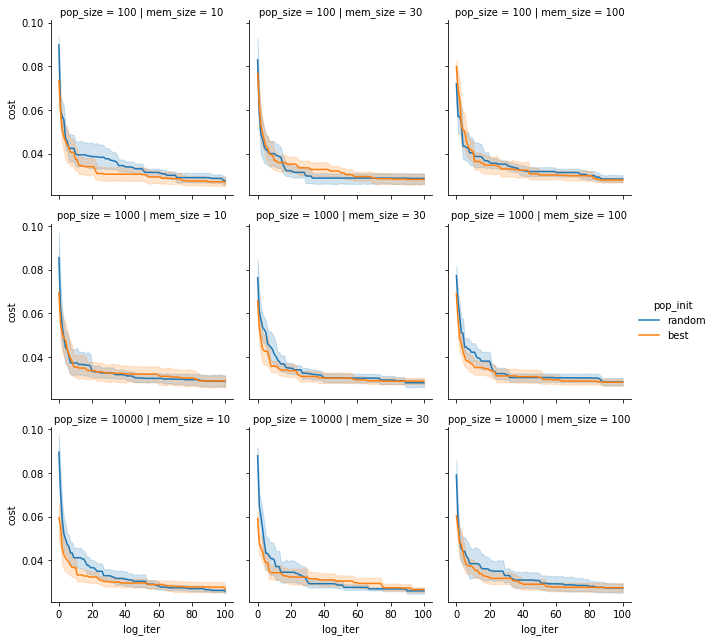

In [231]:
tag = 'tuning_size'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost',row='pop_size', col='mem_size',
            hue='pop_init', kind='line', height=3)

In [232]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['pop_size', 'mem_size', 'pop_init'], as_index=False)['cost'].mean().sort_values('cost').head(10)

,pop_size,mem_size,pop_init,cost
13,10000,10,random,0.025886
15,10000,30,random,0.025957
14,10000,30,best,0.026561
12,10000,10,best,0.026875
0,100,10,best,0.026930
17,10000,100,random,0.027247
16,10000,100,best,0.027384
1,100,10,random,0.027702
4,100,100,best,0.028001
9,1000,30,random,0.028101


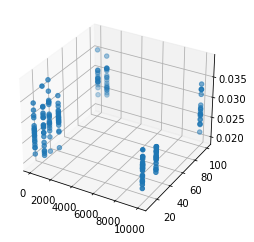

In [235]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(best_data_.pop_size,
           best_data_.mem_size,
           best_data_.cost)

### Mem Consider

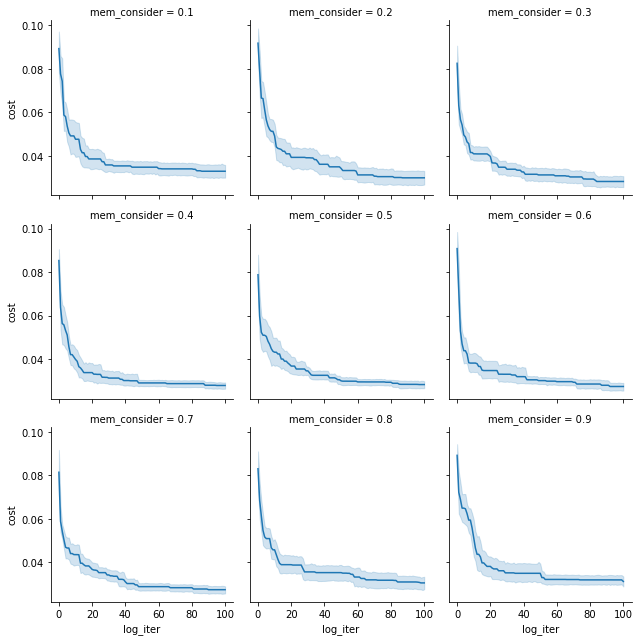

In [140]:
tag = 'tuning_mem'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='mem_consider', col_wrap=3, kind='line', height=3)

In [142]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['mem_consider'], as_index=False)['cost'].mean().sort_values('cost')

,mem_consider,cost
5,0.6,0.027452
6,0.7,0.027466
3,0.4,0.027917
2,0.3,0.028266
4,0.5,0.028342
1,0.2,0.029949
7,0.8,0.030586
8,0.9,0.031248
0,0.1,0.032974


### Par Min | Par Max

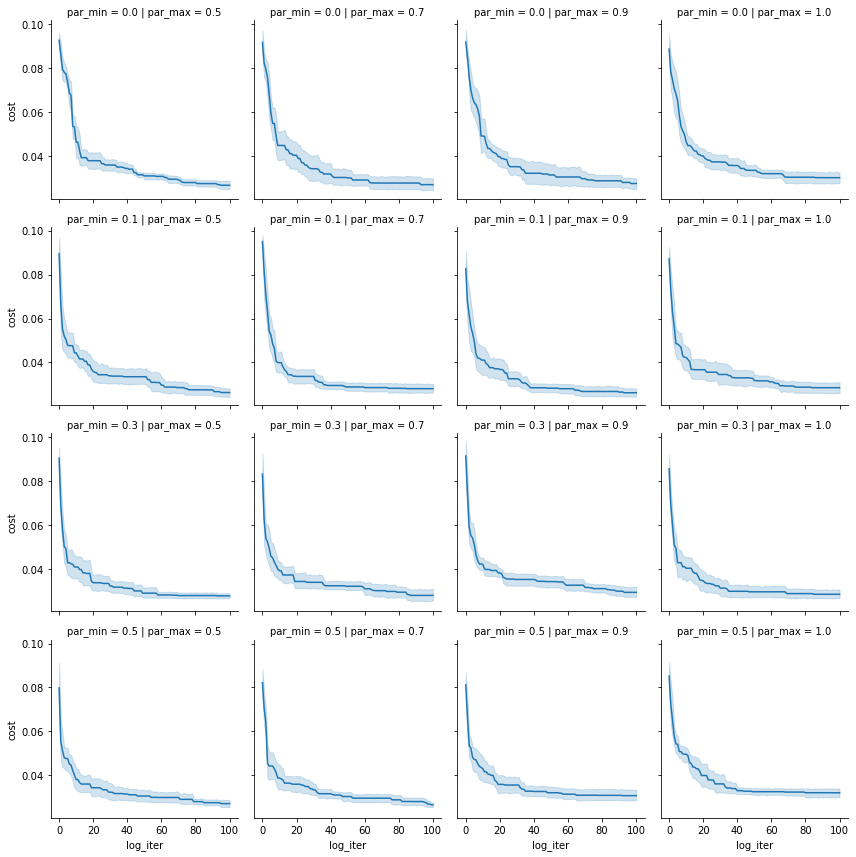

In [143]:
tag = 'tuning_par'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', row='par_min', col='par_max', kind='line', height=3)

In [144]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['par_min', 'par_max'], as_index=False)['cost'].mean().sort_values('cost')

,par_min,par_max,cost
6,0.1,0.9,0.026141
4,0.1,0.5,0.026256
13,0.5,0.7,0.026519
0,0.0,0.5,0.026634
1,0.0,0.7,0.026845
12,0.5,0.5,0.027054
2,0.0,0.9,0.027432
8,0.3,0.5,0.027649
9,0.3,0.7,0.027865
5,0.1,0.7,0.028013


### Bw Min | Bw Max

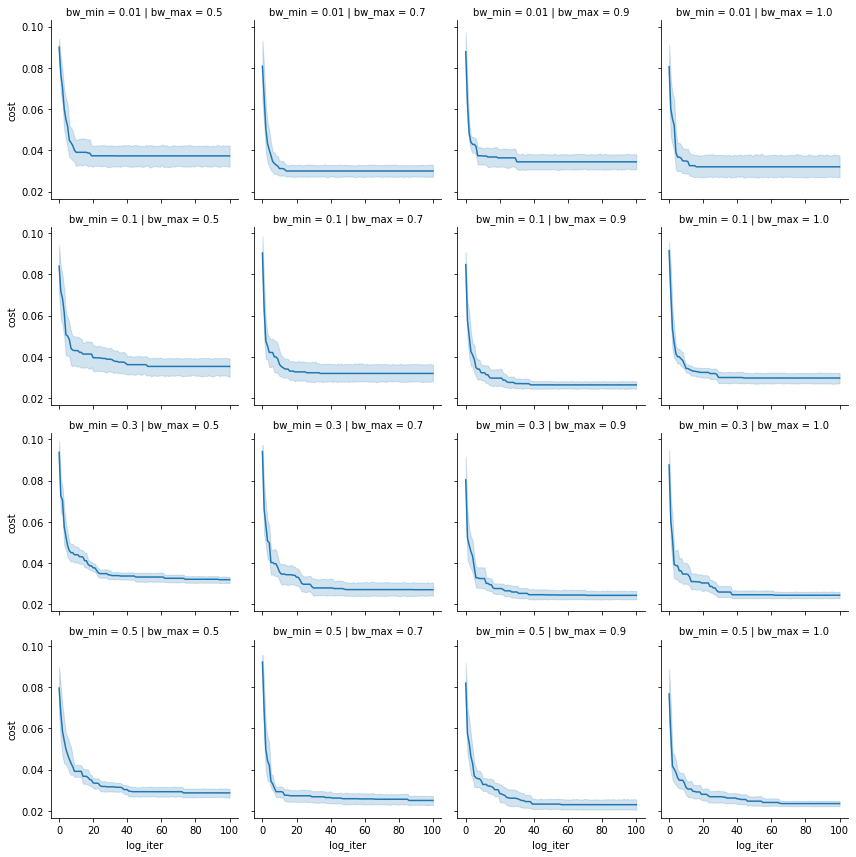

In [154]:
tag = 'tuning_bw'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', row='bw_min', col='bw_max', kind='line', height=3)

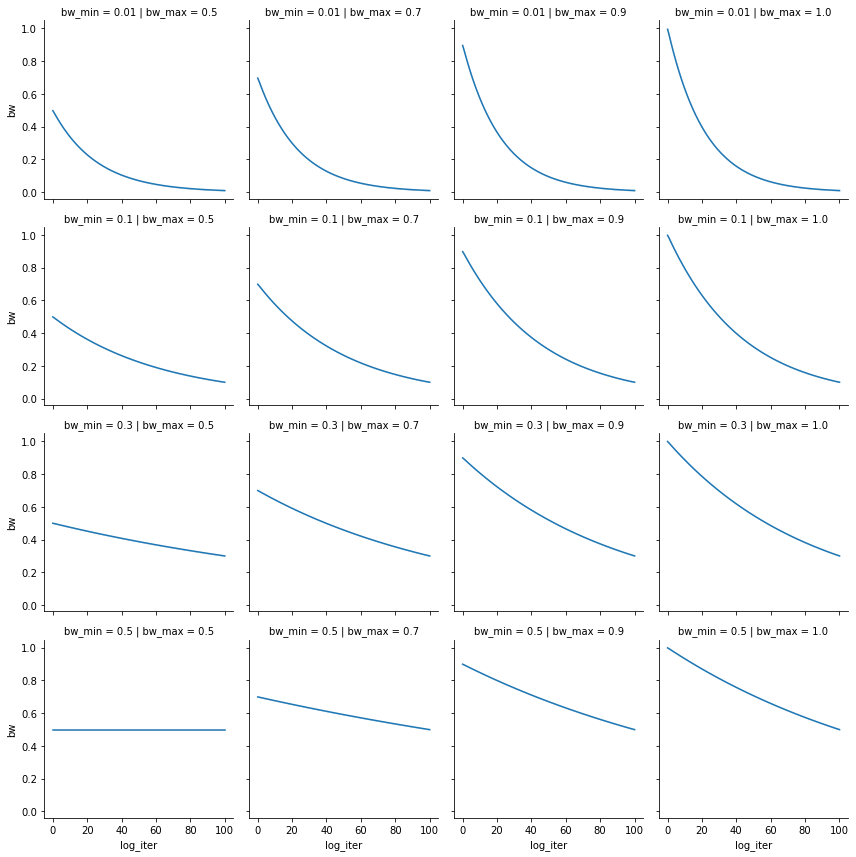

In [299]:
tag = 'tuning_bw'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='bw', row='bw_min', col='bw_max', kind='line', height=3)

In [156]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['bw_min', 'bw_max'], as_index=False)['cost'].mean().sort_values('cost').head(10)

,bw_min,bw_max,cost
14,0.50,0.9,0.023024
15,0.50,1.0,0.023554
10,0.30,0.9,0.024434
11,0.30,1.0,0.024506
13,0.50,0.7,0.025072
6,0.10,0.9,0.026389
9,0.30,0.7,0.027168
12,0.50,0.5,0.028748
7,0.10,1.0,0.029722
1,0.01,0.7,0.030005


### Sigma

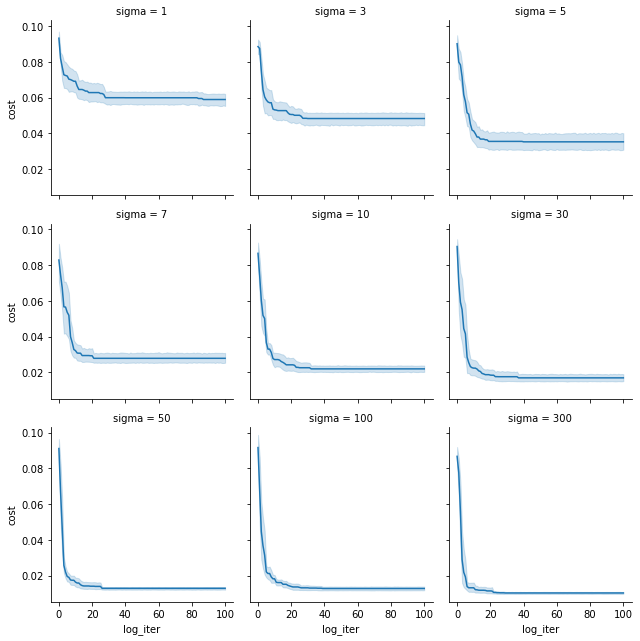

In [180]:
tag = 'tuning_sigma'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='sigma', col_wrap=3, kind='line', height=3)

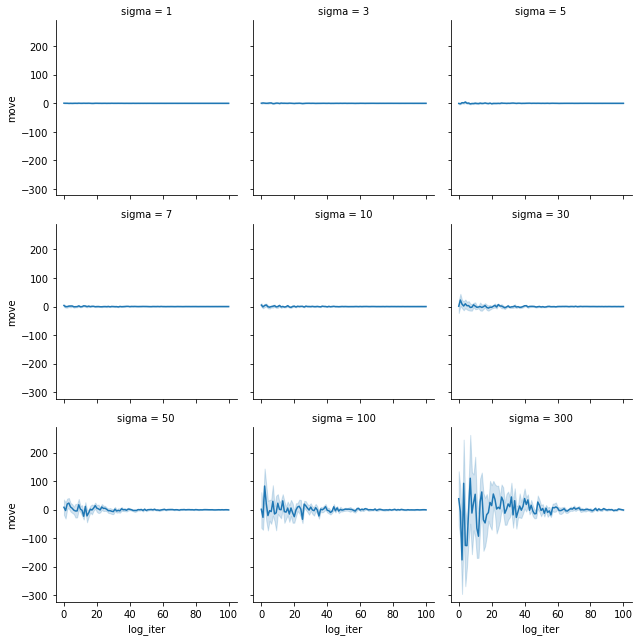

In [181]:
sns.relplot(data=data, x='log_iter', y='move', col='sigma', col_wrap=3, kind='line', height=3)

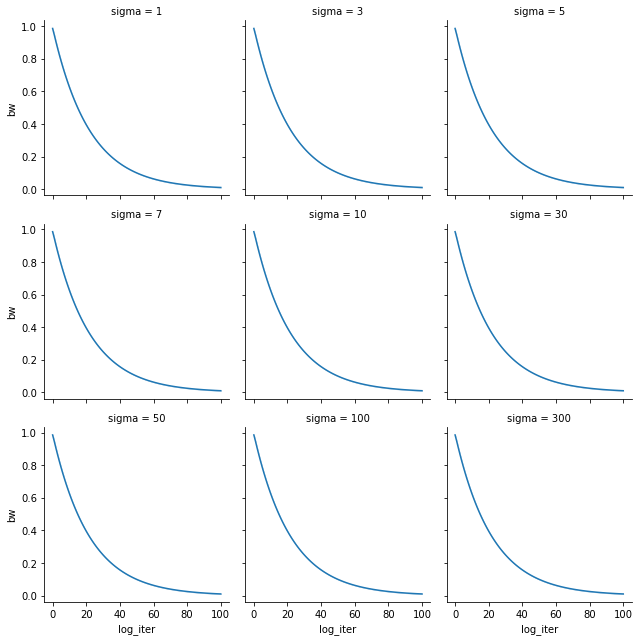

In [182]:
sns.relplot(data=data, x='log_iter', y='bw', col='sigma', col_wrap=3, kind='line', height=3)

In [183]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['sigma'], as_index=False)['cost'].mean().sort_values('cost').head(10)

,sigma,cost
8,300,0.010299
7,100,0.012799
6,50,0.012898
5,30,0.016953
4,10,0.021980
3,7,0.027887
2,5,0.035299
1,3,0.048348
0,1,0.058988


### Iterations

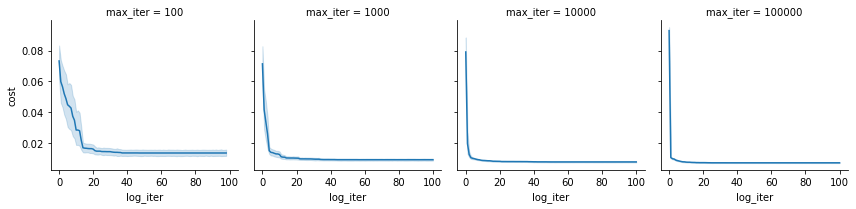

In [297]:
tag = 'tuning_iter'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='max_iter', kind='line', height=3)

In [298]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['max_iter'], as_index=False)['cost'].mean().sort_values('cost')

,max_iter,cost
3,100000,0.007045
2,10000,0.007622
1,1000,0.009054
0,100,0.013431


### Local Search

In [286]:
all_data.local_search.fillna(0, inplace=True)
best_data.local_search.fillna(0, inplace=True)


/Users/rco/opt/anaconda3/envs/abradee/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


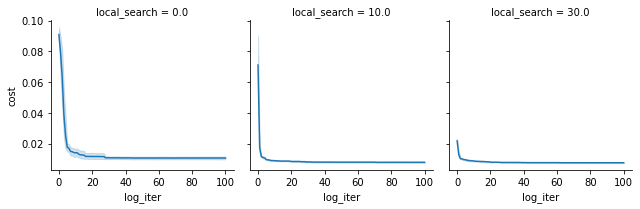

In [283]:
tag = 'tuning_local_search'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='local_search', kind='line', height=3)

In [287]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['local_search'], as_index=False)['cost'].mean().sort_values('cost')

,local_search,cost
2,30.0,0.007505
1,10.0,0.007789
0,0.0,0.010567
